In [1418]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from nltk.corpus import stopwords
import regex as re
import requests
from logging import raiseExceptions
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import contractions
import nltk



import time
import spacy
import spacy.cli

pd.set_option('max_colwidth', 400)






##### Get Submissions method

In [877]:
def get_submission(theme, requests_amount):
    list_submission=[]
    counter=0
    sum=0
    for x in range(1,requests_amount+1):
        url_topic_1=f"https://api.pushshift.io/reddit/search/submission/?subreddit={theme}&fields=selftext,removed_by_category&size=100&before={counter}d"
        req_1=requests.get(url_topic_1)
        #to avoid overrequesting API, code is waiting for a second after request
        time.sleep(1)

        if req_1.status_code==200:
            counter+=1
            sq=req_1.json()            
            for x in sq["data"]:
                ##I am checking "removed by category" field, to exclude spam and inappropriate posts, deleted by bot.
                if "removed_by_category" not in x:
                    list_submission.append(x["selftext"])
                    sum+=1                
        else:
            print(f"There was a mistake {req_1.status_code}")
            return list_submission
    print(f"{sum} submissions downloaded")       
    return list_submission

##### Get commentaries method

In [1086]:
#processing url and getting list of comments

def get_comment(theme,quant):
    list_comments=[]
    counter=0
    for x in range(1,36,2):
        url_topic_1=f"https://api.pushshift.io/reddit/search/comment/?size={quant}&subreddit={theme}&before={x}d"
        req_1=requests.get(url_topic_1)
        if counter%2==0:
            #Waiting for a second each 2nd request
            time.sleep(1)
        if req_1.status_code==200:
            counter+=1
            sq=req_1.json()            
            for x in sq["data"]:
                list_comments.append(x['body'])                
        else:
            return f"Code was {req_1.status_code}"
    return list_comments

##### Cleaning with RegExp

In [1537]:
#using regexp to clean recieved comments
def clean(sq):
    sq=[x.lower() for x in sq if x.find("Your submission has been")==-1] #drops posts of antispam bot
    sq=[x.lower() for x in sq if x.find("delete")==-1] # drops posts with "delete" in them
    sq=[x.lower() for x in sq if x.find("title")==-1] 
    sq=[re.sub("(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)"," ", x.lower()) for x in sq] #drops all links
    sq=[re.sub("(.)\1{2}"," ", x.lower()) for x in sq] # drops all words where 3 same letters are put together like "aaaaand", "soooooo"
    sq=[re.sub("\W+"," ", x.lower()) for x in sq] #drops all whitespace symbols like \n \t etc.
    sq=[re.sub("\w*\d\w*"," ", x.lower()) for x in sq] #drops all words with numbers in them 
    sq=[re.sub("\s[a-z]{1,2}\s"," ", x.lower()) for x in sq] #drops all two letter words, because almost all of them are Stop-words
    sq=[re.sub("\s[a-z]{1,1}\s"," ", x.lower()) for x in sq] #drops all one letter words,for some reason previous regex left some of those
    sq=[x.lower() for x in sq if x.find("removed")==-1] #drops "removed" comments, sent by api 
    sq=set(sq) #Leaving only unique values

    
    return sq


### Downloading and cleaning comments

In [1088]:
AskMan_comment=get_comment("AskMen",130)
len(set(AskMan_comment))

2183

In [1089]:
AskWoman_comment=get_comment("AskWomen",130)
len(set(AskWoman_comment))

2096

Adding columns for classification and saving dataset

In [1104]:
AskMan_comment=clean(set(AskMan_comment))
AskMan_comment_df=pd.DataFrame(AskMan_comment)
AskMan_comment_df['sex']=1
AskMan_comment_df.columns=["comment",'sex']

AskWoman_comment=clean(set(AskWoman_comment))
AskWoman_comment_df=pd.DataFrame(AskWoman_comment)
AskWoman_comment_df['sex']=0
AskWoman_comment_df.columns=["comment",'sex']

AskMan_comment_df.shape, AskWoman_comment_df.shape

In [ ]:
final_comment_df=pd.concat([AskMan_comment_df,AskWoman_comment_df])
final_comment_df.reset_index(inplace=True,drop=True)
final_comment_df

final_comment_df.to_csv('../data/df_comments.csv',index=False)

----

### Downloading Submissions

In [839]:
AskMan=get_submission("AskMen",130)


5335 submissions downloaded


In [840]:
len(set(AskMan))

2682

In [842]:
AskWoman=get_submission("AskWomen",130)
len(set(AskWoman))


5665 submissions downloaded


2080

In [1538]:
c_ask_man=clean(AskMan)
c_ask_woman=clean(AskWoman)
print(f"Unique AskMan comments:  {len(c_ask_man)}")
print(f"Unique AskWoman comments: {len(c_ask_woman)}")

Unique AskMan comments:  2594
Unique AskWoman comments: 2017


Adding target column for future classification

In [1539]:
df_cleaned_man=pd.DataFrame(data=c_ask_man)
df_cleaned_man["sex"]=1
df_cleaned_man.columns = ["comment","sex"]
df_cleaned_man=df_cleaned_man[df_cleaned_man["comment"]!=""]
df_cleaned_man


,comment,sex
1,it happened today for and was told friend that talking me like therapy feel like that the best thing anyone has ever said me got thinking what are your all experiences,1
2,is turn off woman makes the first move wanna hook with man going date with couple days he doesn make the first move want is unsettling woman wants hook the first date what kind impression you get from them don sleep around often don wanna give him that impression just type,1
3,my parents and family over the holidays put on the spot during dinner and asked about dating life told them that dating but nothing serious going pretty busy with career and just hanging with friends been out relationship for while has anyone dealt with this made feel pretty shitty seeing their reactions also being that weird age where everyone getting married are serious relationships gives f...,1
4,context about ask about what do the first few exchanges despite being my profile now curious why there are those who dont read the profile and write ups,1
5,with the intention send to other people besides your,1
...,...,...
2589,i want remove pubic hair but honestly don know what the best method do want do safe and efficient don know depilatory cream safe use that part my body laser not option for right now,1
2590,i have this friend whom am having some fun with asked where want him finish,1
2591,with soft normal grip and normal stroking ponr point no return basically know most people edge which causes them last long but wondering about the initial ponr curious worry might reaching too fast,1
2592,if you were going through stresses life would you upset your girlfriend still wanted attention least phone calls,1


In [1540]:
df_cleaned_woman=pd.DataFrame(data=c_ask_woman)
df_cleaned_woman["sex"]="0"
df_cleaned_woman.columns = ["comment","sex"]
df_cleaned_woman=df_cleaned_woman[df_cleaned_woman["comment"]!=""]
df_cleaned_woman

,comment,sex
1,i find that have trouble missing ex the weekends and wondering women experience that too,0
2,hello new here and would like make new friends and just have conversations ️ ️,0
3,would you raise your baby gender neutral,0
4,i just second baby weeks ago have been looking old pictures myself and really obsessing over the fact that will never look that good again the saggy boobs stomach stretch marks and separation are here stay any tips for accepting yourself for who you are and for lack better term being less vain,0
5,my wife and can settle which would have more advantages for spouse,0
...,...,...
2012,did you tell the truth any way did threaten sue you what did you,0
2013,women where are you the most receptive being approached someone who interested,0
2014,i have noticed many women feeling shame around certain topics sex incontinence child rearing parenting etc and am wondering what the topic most you wish people would more open and honest about,0
2015,i like wear them because don really need bra but when the top comes off do not want him seeing it like seeing someone without eyebrows suggestions,0


Concatenating final united dataframe

In [1541]:
final_df=pd.concat([df_cleaned_man[:2056],df_cleaned_woman[:]],ignore_index=True)

In [1542]:
final_df.shape

(4072, 2)

In [1543]:
final_df.head()

,comment,sex
0,it happened today for and was told friend that talking me like therapy feel like that the best thing anyone has ever said me got thinking what are your all experiences,1
1,is turn off woman makes the first move wanna hook with man going date with couple days he doesn make the first move want is unsettling woman wants hook the first date what kind impression you get from them don sleep around often don wanna give him that impression just type,1
2,my parents and family over the holidays put on the spot during dinner and asked about dating life told them that dating but nothing serious going pretty busy with career and just hanging with friends been out relationship for while has anyone dealt with this made feel pretty shitty seeing their reactions also being that weird age where everyone getting married are serious relationships gives f...,1
3,context about ask about what do the first few exchanges despite being my profile now curious why there are those who dont read the profile and write ups,1
4,with the intention send to other people besides your,1


Checking for nulls and column types

In [1544]:
final_df.isnull().sum()

comment    0
sex        0
dtype: int64

In [1545]:
final_df.dtypes

comment    object
sex        object
dtype: object

"Sex" column is binary and should be int.

In [1546]:
final_df["sex"]=final_df["sex"].astype(int)
final_df.dtypes

comment    object
sex         int64
dtype: object

In [1293]:
#saving file
final_df.to_csv("../data/df_submissions.csv",index=False)

----

### Expanding Contractions

In [1547]:
def expand(document):
    result=""
    for word in document.split(" "):        
        result+=contractions.fix(word)
        result+=" "
    return result.strip()

In [1548]:
final_df['comment']=final_df['comment'].apply(lambda x: expand(x))

----

### Processing in SpaCy 

(I didn't use pipelines, because I've used stages for modeling)

In [ ]:
spacy.cli.download('en_core_web_md')
nlp = spacy.load('en_core_web_md')

Lemmatizing each word and dropping aux

In [1360]:
def drop_aux(docs):
    cleaned=""
    nlp_doc=nlp(docs)
    for word in nlp_doc:
        if word.pos_!="AUX":
            cleaned+=str(word.lemma_)
            cleaned+=" "
    return cleaned.strip()


Dropping all the empty rows which could ppear after aux cleaning

In [1549]:
final_df['comment']=final_df["comment"].apply(lambda x: drop_aux(x))
#Dropping all possible empty rows, which contained only aux
final_df=final_df[final_df["comment"]!=""]

----

### Compairing submissions

after modeling find most useful posts and compare submissions with those words. Find best words.

In [ ]:

df_comparing=pd.DataFrame(columns=["mcomment","wcomment","score"])
df_comparing
for mcomment in df_cleaned_man["comment"]:
    for wcomment in df_cleaned_woman["comment"]:
        mnlp=nlp(mcomment)
        wnlp=nlp(wcomment)
        score=mnlp.similarity(wnlp)
        if score>0.9:
            print (mcomment, wcomment)
        # temp={"mcomment":mcomment,"wcomment":wcomment,"score":score}
        # df_comparing.append(temp,ignore_index=True)

### Check for Sentiment Scores

In [1125]:
sent= SentimentIntensityAnalyzer()

In [1488]:
result=[]
for mcomment in df_cleaned_man["comment"]:    
    score=sent.polarity_scores(mcomment)
    temp={"comment":mcomment,"score":score["compound"]}
    result.append(temp)
    # df_man_sentiment.append(temp,ignore_index=True)
df_man_sentiment=pd.DataFrame(data=result)

df_man_sentiment.sort_values(by=["score"],ascending=False)

,comment,score
908,this very long post thanks for taking the time read and advise you as the title tells looking do almost total reinventing myself for personal improvement get ready for the next step my life have broken down the changes need make categories any insight into these would greatly appreciated style and dress ve never been one consider care what others thought me nor have ever put much thought into ...,0.9995
645,im worried that will just deny because feels ashamed thinks might lose this isn the case be honest don have issue he wants sleep with other girls understand some people are just like that and want him be happy used have issue with as lied me when found out was hitting this other woman while said wanted to exclusive but don anymore do however have issue with dishonesty also portrayed lot things...,0.9988
1427,a couple months ago one my friends ll call her tayla that in long term relationship mentioned one her guy friends will call him will she grew with single and her and her partner wanted set up with him she showed photo but said said slept with another one our friends within the group ll call her jess back when they were high school high school was good years ago for but was still uninterested...,0.9986
640,i go first before start off the new year years old and one the things want out life to make least in job love do either marketing business tech the next thing want lovely wife who also career driven amazing loyal supportive and god fearing doesn matter me how much money she makes but just want lovely wife want own beautiful huge log cabin house share with wife want have pets own weapons ...,0.9982
1799,so uni the group people talking about all living dorms campus re great group friends closest friends are guy and girl who somewhat interested but being the less funny less attractive less interesting person she would not interested me back accepted the fate friendship which isn too bad itself but the guy has been interested her for quite some time and actively trying persue something out i...,0.9981
...,...,...
746,scenario you just got home after work and around midnight you tired but suddenly you hear your daughter son scream for help louder than you ever thought possible and you run their bedroom where they should have been asleep but the time you get there they are dead the murderer standing above them holding the murder weapon you happen be holding gun how you react for extra context you know for fa...,-0.9870
856,hi men reddit over the last year ve been making conscious effort become assertive after many years poor treatment from various people my life ve taken boxing practiced stronger eye contact been quicker make complaints about bad service etc ve long way go but slowly feel myself becoming less pushover and think people general have been little nicer me maybe carrying myself differently dunno but ...,-0.9900
965,oh boy here go maybe some background about will help was raised my single mother alongside two elder sisters didn have necessarily bad relationship with father growing we just weren close matter how much mother tried have spend time together when got my late teens decided would stop seeing him and putting the effort because never reached out me and never seemed care that much but like said the...,-0.9929
59,i have reason be shitting myself but can sleep anymore just workout exhaustion but still every night when fall my bed fell this horrible fear afraid suffering violence some hipotical injustice some lovedones suffering am mess for reason this happening frequently for almost years but have memories being teenager and just whacthing on because was afraid try talk my girlfriend but she didn unde...,-0.9936


<Figure size 432x288 with 0 Axes>

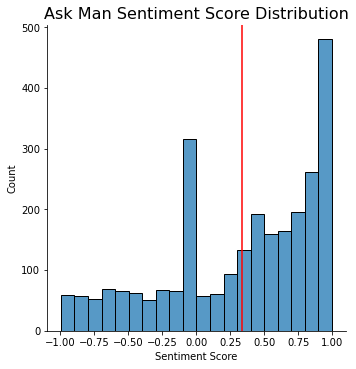

In [1502]:
plt.tight_layout()
sns.displot(df_man_sentiment.score, bins=20)
plt.xlabel("Sentiment Score", size=10)
plt.ylabel("Count", size=10)
plt.axvline(x=df_man_sentiment.score.mean(),
            color='red')
plt.title("Ask Man Sentiment Score Distribution", size = 16)
plt.savefig('../recourse/AskWomanSantiment.png')


In [1489]:
result=[]

for wcomment in df_cleaned_woman["comment"]:    
    score=sent.polarity_scores(wcomment)
    temp={"comment":wcomment,"score":score["compound"]}
    result.append(temp)
df_woman_sentiment=pd.DataFrame(result)
df_woman_sentiment.sort_values(by="score",ascending=False)

,comment,score
655,so this friend will call her old friend and have known each other since were grade even though didn really talk much until the start high school now re university different university btw she and this other friend were the two people mostly talked throughout high school met another friend will call her the new friend my last year high school and after few years knowing her she asked for numb...,0.9994
1203,really random thought here but was just wondering young woman myself and just find that girls can extremely rude and aggressive towards one another and not only that but also fake have few good friends that are women they are cool and love them but sometimes their about them attitudes can so nasty for reason asked one them simple question and she got irritated and nastywith that other fri...,0.9987
1598,this got bit long but feel the details are important couple weeks ago this girl matched with tinder she was cute but not your stereotypical beauty someone that was definitely my league she immediately commented how cute was one my photos and after few texts she asked to hang out later that night worked early we didn end hanging out but exchanged handful more texts that night and the next m...,0.9986
174,this got bit long but feel the details are important couple weeks ago this girl matched with tinder she was cute but not your stereotypical beauty someone that was definitely my league she immediately commented how cute was one my photos and after few texts she asked to hang out later that night worked early we didn end hanging out but exchanged handful more texts that night and the next m...,0.9985
304,for context friend and have been best friends since grade am now married husband friend visiting from florida month after moved california re still settling but thought would good idea come for his which the time thought would too aslong had job well got that job and not the kind job can just call off willy nilly just request off whenever tried express that since was new job wasn gon...,0.9979
...,...,...
1390,when have sex all she wanted was for to fuck her and that it wouldn let finger her anything else literally just kiss and fuck was honestly the worst sex ever had effort was one sided but because liked her and ignored all needs were not met once through out the short relationship she would odd things like say fuck here were outside and course was that but then seconds later bring someth...,-0.9899
1374,to brother thanks for being home early and showering normally have very short min time frame every weekday when home alone perfect time frame quickly shower put clean hygiene product and throw away the waste the garbage can outside without someone hovering over it was plan had been plan all day didn want step outside room and have mother me questioning every move and watching like hawk but y...,-0.9928
1642,to brother thanks for being home early and showering normally have very short min time frame every weekday when home alone perfect time frame quickly shower put clean hygiene product and throw away the waste the garbage can outside without someone hovering over it was plan had been plan all day didn want step outside room and have mother me questioning every move and watching like hawk but y...,-0.9928
1097,does anyone else just get sick being around your partner family feel terrible for saying this but just wanted unbiased opinion his family are big socializers his several aunties and mum drink regularly together and see each other every weekend don get wrong love close family bonds but when they start drinking they start talking shit about everyone and even between themselves is almost contest ...,-0.9949


<Figure size 432x288 with 0 Axes>

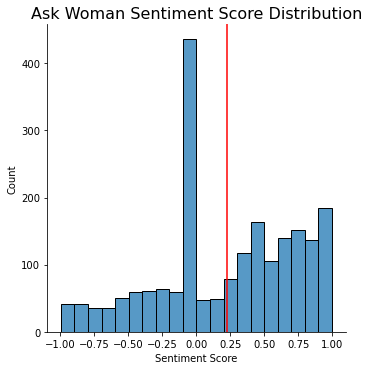

In [1501]:
plt.tight_layout()
sns.displot(df_woman_sentiment.score, bins=20)
plt.xlabel("Sentiment Score", size=10)
plt.ylabel("Count", size=10)
plt.axvline(x=df_woman_sentiment.score.mean(),
            color='red')
plt.title("Ask Woman Sentiment Score Distribution", size = 16)
plt.savefig('../recourse/AskWomanSantiment.png')


----

/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


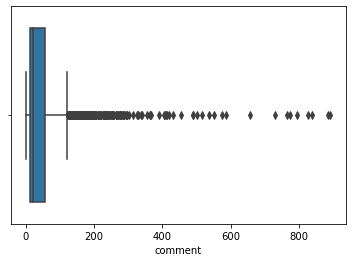

In [1555]:

plt.tight_layout()
sns.boxplot(final_df['comment'].str.split(" ").str.len())
plt.savefig('../recourse/BoxPlot.png')

Dropping Stopwords

In [1551]:

def drop_stopwords(str):
    result=""
    for word in str.split(' '):
        if word not in nlp.Defaults.stop_words:
            if word not in stopwords.words('english'):
                result+=word
                result+=" "

    return result.strip()

In [1553]:
df=final_df.copy()
df['comment']=df['comment'].apply(lambda x: drop_stopwords(x))
df=df[df['comment']!=""]

df

,comment,sex
0,happen today tell friend talk I like therapy feel like good thing I think experience,1
1,turn woman want hook man date couple day want unsettle woman want hook date kind impression sleep want impression type,1
2,parent family holiday spot dinner ask date life tell date pretty busy career hang friend relationship deal feel pretty shitty reaction weird age marry relationship feeling leave friend single vibe friend family relationship past year wrong damage good,1
3,ask exchange despite profile curious read profile write,1
4,intention send people,1
...,...,...
4067,tell truth way threaten sue,0
4068,woman receptive approach interest,0
4069,I notice woman feel shame certain topic sex incontinence child rear parenting etc wonder topic wish people open honest,0
4070,I like wear need bra come want like eyebrow suggestion,0


Saving point

In [1554]:
#saving file
df.to_csv("../data/df_submissions.csv",index=False)

In [1559]:
df["sub_word_count"]=df['comment'].str.split(" ").str.len()
df["sub_length"]= df['comment'].str.len()

In [1560]:
df.sort_values(by="sub_word_count")

,comment,sex,sub_word_count,sub_length
2853,late,0,1,4
3446,overthinke,0,1,10
1042,difference,1,1,10
2805,throw,0,1,5
776,hype,1,1,4
...,...,...,...,...
2353,context friend good friend grade marry husband friend visit florida month california settle think good idea come time thought aslong job job kind job willy nilly request express new job able time job time frame come discuss job maybe week come feel right request time jeopardize position good job like good money pay huge sum friend live stock freelance work live alot time want...,0,354,1894
3621,bit long feel detail important couple week ago girl match tinder cute stereotypical beauty definitely league immediately comment cute photo text ask hang later night work early end hang exchange handful text night morning ask hang night busy forget reply persistent meet intrigue figure know want end night later decent time bar feel natural hit lot common friend pretty drunk touch thigh s...,0,401,2338
2324,sister turn day ago mum british bear pakistani come like ton brick regard marriage sister toxic childish manipulate argumentative immature think mum pick want rid regardless good day sister nice girl introverted speak guy life mind relationship awkward old fashioned regard sex dating etc speak marriage want marry mum desperate sister find lot poor experience fail arrange marriage hu...,0,420,2620
2227,bit long feel detail important couple week ago girl match tinder cute stereotypical beauty definitely league immediately comment cute photo text ask hang later night work early end hang exchange handful text night morning ask hang night busy forget reply persistent meet intrigue figure know want end night later decent time bar feel natural hit lot common friend pretty drunk touch thigh s...,0,423,2472


EDA by subreddit

In [1569]:
df.groupby('sex').agg(['mean',"max","min"])

sub_word_count           sub_length          
              mean  max min        mean   max min
sex                                              
0        20.142287  470   1  120.765352  2660   1
1        28.254643  349   1  167.806452  2052   1

<Figure size 432x288 with 0 Axes>

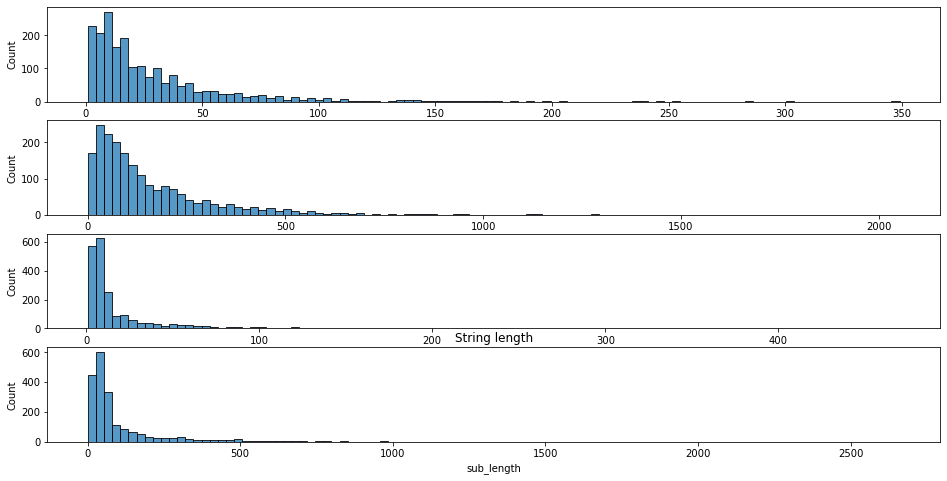

In [1514]:

plt.tight_layout()
fig, (ax1, ax2,ax3,ax4) = plt.subplots(4,1, figsize=(16,8))
plt.title("String length")

sns.histplot(df[df["sex"]==1]['sub_word_count'], ax=ax1,bins=100,)
sns.histplot(df[df["sex"]==1]['sub_length'], ax=ax2,bins=100)
ax1.set_xticks="ddd"
sns.histplot(df[df["sex"]==0]['sub_word_count'], ax=ax3,bins=100)
sns.histplot(df[df["sex"]==0]['sub_length'], ax=ax4,bins=100)
plt.show()

In [1451]:
df[df["sex"]==1]['sub_word_count'].describe(),df[df["sex"]==0]['sub_word_count'].describe()

(count    2046.000000
 mean       28.551320
 std        32.520658
 min         1.000000
 25%         8.000000
 50%        17.000000
 75%        37.000000
 max       349.000000
 Name: sub_word_count, dtype: float64,
 count    2043.000000
 mean       20.423886
 std        36.788706
 min         1.000000
 25%         5.000000
 50%         9.000000
 75%        19.000000
 max       470.000000
 Name: sub_word_count, dtype: float64)

In [1570]:
df[df["sex"]==1]['sub_length'].describe(),df[df["sex"]==0]['sub_length'].describe()

(count    2046.000000
 mean      167.806452
 std       189.760371
 min         1.000000
 25%        50.000000
 50%       106.000000
 75%       216.750000
 max      2052.000000
 Name: sub_length, dtype: float64,
 count    2003.000000
 mean      120.765352
 std       215.469151
 min         1.000000
 25%        30.000000
 50%        52.000000
 75%       116.000000
 max      2660.000000
 Name: sub_length, dtype: float64)

<AxesSubplot:>

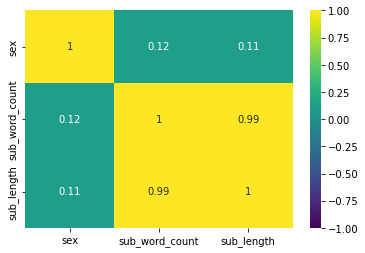

In [1453]:
sns.heatmap(df.corr(),annot=True, vmin=-1,vmax=1,cmap="viridis")

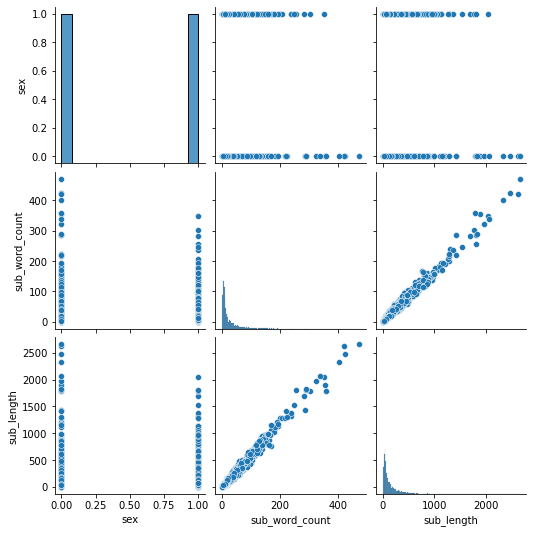

In [1454]:
sns.pairplot(df)

In [1587]:
whitespaces_drop = lambda s: " ".join(s.split())
bigram_freq = lambda s: list(nltk.FreqDist(nltk.bigrams(s.split(" "))).items())


out = df['comment'].apply(whitespaces_drop)
out=clean(out)
out = df['comment'].apply(bigram_freq).explode()
out = pd.DataFrame(out.to_list(), index=out.index, columns=["submissions", "bigrams"])
out.value_counts()

submissions         bigrams
(, )                2.0        454
(feel, like)        1.0        260
(, )                4.0        231
(, year)            1.0        200
(I, )               1.0        133
                              ... 
(huge, saggy)       1.0          1
(huge, scent)       1.0          1
(huge, screaming)   1.0          1
(huge, societal)    1.0          1
(like, difference)  1.0          1
Length: 66228, dtype: int64

In [1576]:
out.value_counts()

submissions         bigrams
(, )                2.0        454
(feel, like)        1.0        260
(, )                4.0        231
(, year)            1.0        200
(I, )               1.0        133
                              ... 
(huge, saggy)       1.0          1
(huge, scent)       1.0          1
(huge, screaming)   1.0          1
(huge, societal)    1.0          1
(like, difference)  1.0          1
Length: 66228, dtype: int64

In [1458]:
bigram_freq = lambda s: list(nltk.FreqDist(nltk.trigrams(s.split(" "))).items())

out = df['comment'].apply(bigram_freq).explode()
out = pd.DataFrame(out.to_list(), index=out.index, columns=["submissions", "bigrams"])
out.value_counts().head(15)

submissions    bigrams
(, , )         1.0        453
(, , year)     1.0        199
(, , )         2.0        171
(I, , )        1.0        134
(, , )         3.0        122
(, , month)    1.0         78
(, , )         4.0         77
(like, , )     1.0         76
(, year, old)  1.0         70
(, , )         5.0         64
(, , time)     1.0         53
(, , week)     1.0         44
(, , day)      1.0         39
(, , hour)     1.0         31
(, , year)     2.0         29
dtype: int64

# Tokenization

In [1462]:
def get_tokens(docs):
    df_tokens = []
    for x in docs:
        man=nlp(x)
        for token in man:
            t_dict = {
            'text': token,
            'POS': token.pos_,
            'POS explained': spacy.explain(token.pos_),        
            'lemma': token.lemma_
            }
            df_tokens.append(t_dict)
        
    return pd.DataFrame(df_tokens)

In [1515]:
docs_man = list(nlp.pipe(df[df['sex']==1]["comment"]))
docs_woman = list(nlp.pipe(df[df['sex']==0]["comment"]))

In [1516]:
df_man_tokens=get_tokens(docs_man)
df_woman_tokens=get_tokens(docs_woman)


In [1517]:
df_man_tokens.shape

(55611, 4)

In [1518]:
df_man_tokens[df_man_tokens["POS"]=="AUX"].shape

(279, 4)

In [1519]:
df_man_tokens=get_tokens(docs_man)
df_woman_tokens=get_tokens(docs_woman)


In [1520]:
df_man_tokens.reset_index(inplace=True)
df_man_tokens.drop(columns='index',inplace=True)

In [1521]:
df_man_tokens

,text,POS,POS explained,lemma
0,happen,VERB,verb,happen
1,today,NOUN,noun,today
2,tell,VERB,verb,tell
3,friend,NOUN,noun,friend
4,talk,NOUN,noun,talk
...,...,...,...,...
55606,nice,ADJ,adjective,nice
55607,guy,NOUN,noun,guy
55608,ghost,NOUN,noun,ghost
55609,wonder,NOUN,noun,wonder


<AxesSubplot:>

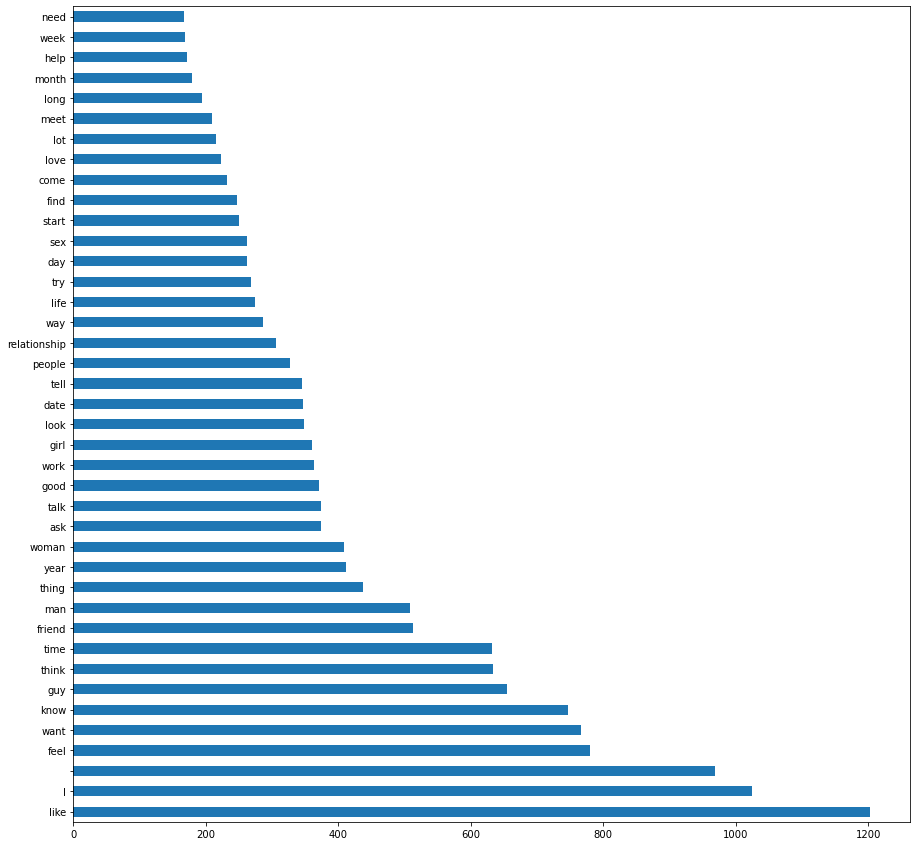

In [1522]:
plt.figure(figsize=(15,15))
df_man_tokens["lemma"].value_counts().sort_values(ascending=False).head(40).plot(kind="barh")

### Now let's look at the most popular words in the AskWoman section

In [1523]:
df_woman_tokens[df_woman_tokens["POS"]=="AUX"].sample(10)

,text,POS,POS explained,lemma
33036,try,AUX,auxiliary,try
39733,let,AUX,auxiliary,let
23296,know,AUX,auxiliary,know
37039,need,AUX,auxiliary,need
1010,try,AUX,auxiliary,try
20234,want,AUX,auxiliary,want
36619,try,AUX,auxiliary,try
20226,let,AUX,auxiliary,let
14555,let,AUX,auxiliary,let
2533,try,AUX,auxiliary,try


<AxesSubplot:>

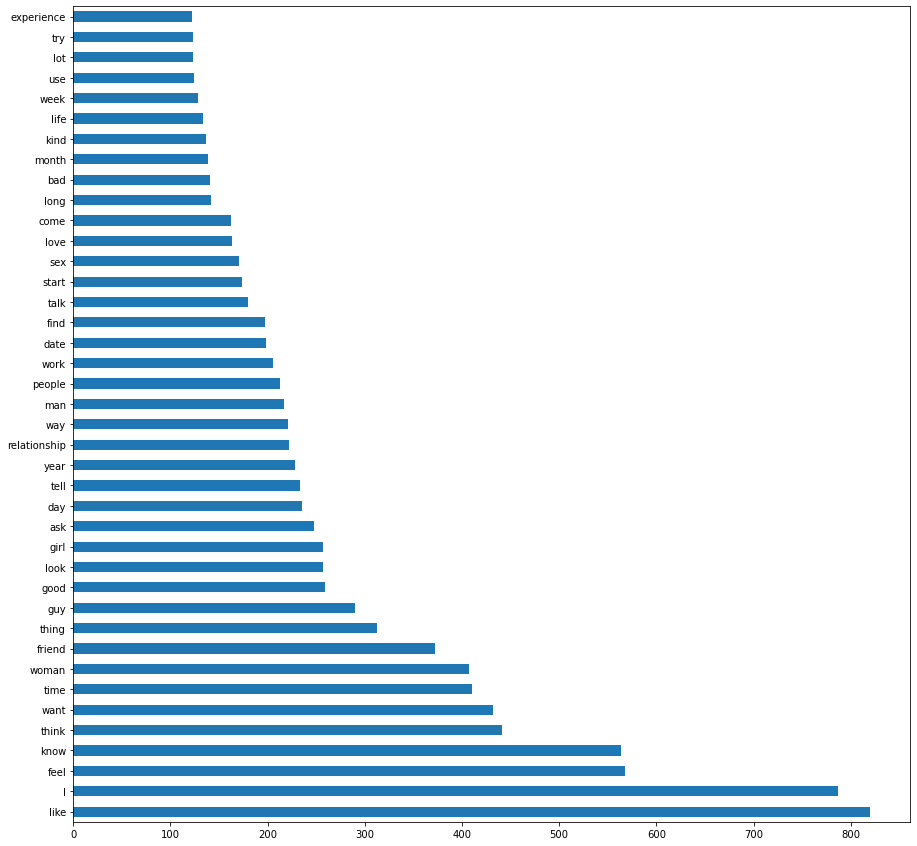

In [1524]:
df_woman_tokens=df_woman_tokens[df_woman_tokens["POS"]!="AUX"]
df_woman_tokens=df_woman_tokens[df_woman_tokens["POS"]!="SPACE"]
# df_woman_tokens=df_woman_tokens[df_woman_tokens["POS"]!="PROPN"]
df_woman_tokens.reset_index(inplace=True)
df_woman_tokens.drop(columns='index',inplace=True)
plt.figure(figsize=(15,15))
df_woman_tokens["lemma"].value_counts().sort_values(ascending=False).head(40).plot(kind="barh")

Almost all of most frequent words are Stopwords. 

### Removing StopWords


In [1525]:
print(df_man_tokens.shape[0])
df_man_tokens_stopwords=df_man_tokens[~df_man_tokens['lemma'].isin(nlp.Defaults.stop_words)]
print(df_man_tokens_stopwords.shape[0])
df_man_tokens_stopwords=df_man_tokens_stopwords[~df_man_tokens_stopwords['lemma'].isin(stopwords.words('english'))]
print(df_man_tokens_stopwords.shape[0])


55611
55592
55592


In [1526]:
print(df_woman_tokens.shape[0])
df_woman_tokens_stopwords=df_woman_tokens[~df_woman_tokens['lemma'].isin(nlp.Defaults.stop_words)]
print(df_woman_tokens_stopwords.shape[0])
df_woman_tokens_stopwords=df_woman_tokens_stopwords[~df_woman_tokens_stopwords['lemma'].isin(stopwords.words('english'))]
print(df_woman_tokens_stopwords.shape[0])

38825
38817
38817


<AxesSubplot:>

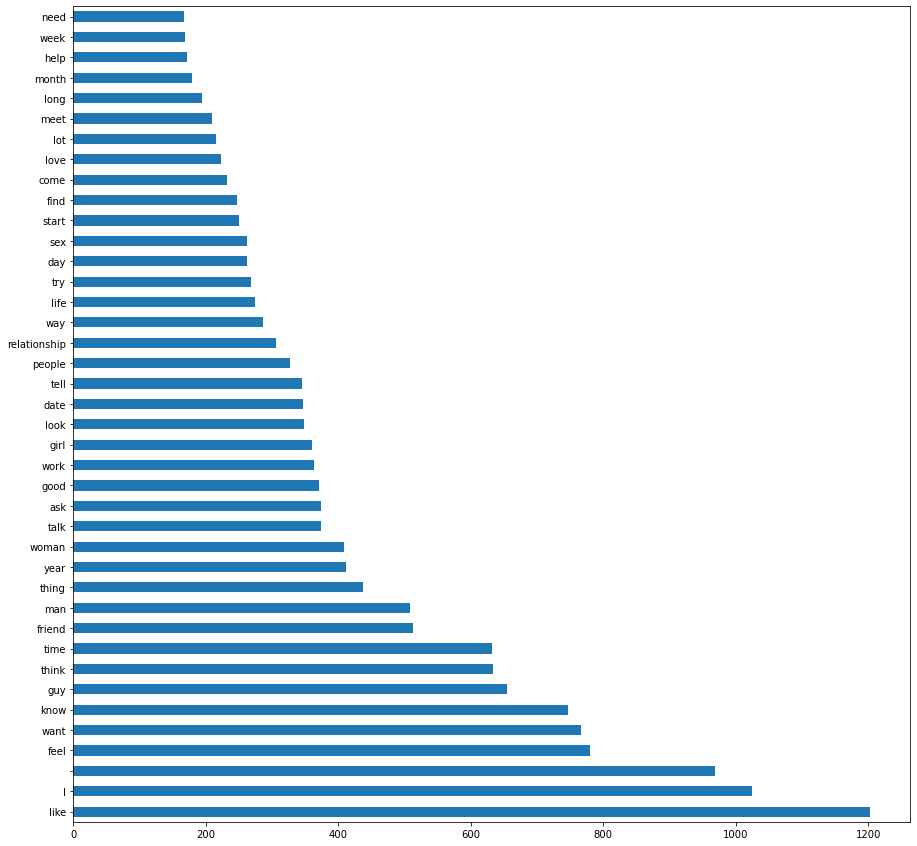

In [1527]:
plt.figure(figsize=(15,15))
df_man_tokens_stopwords["lemma"].value_counts().sort_values(ascending=False).head(40).plot(kind="barh")

<AxesSubplot:>

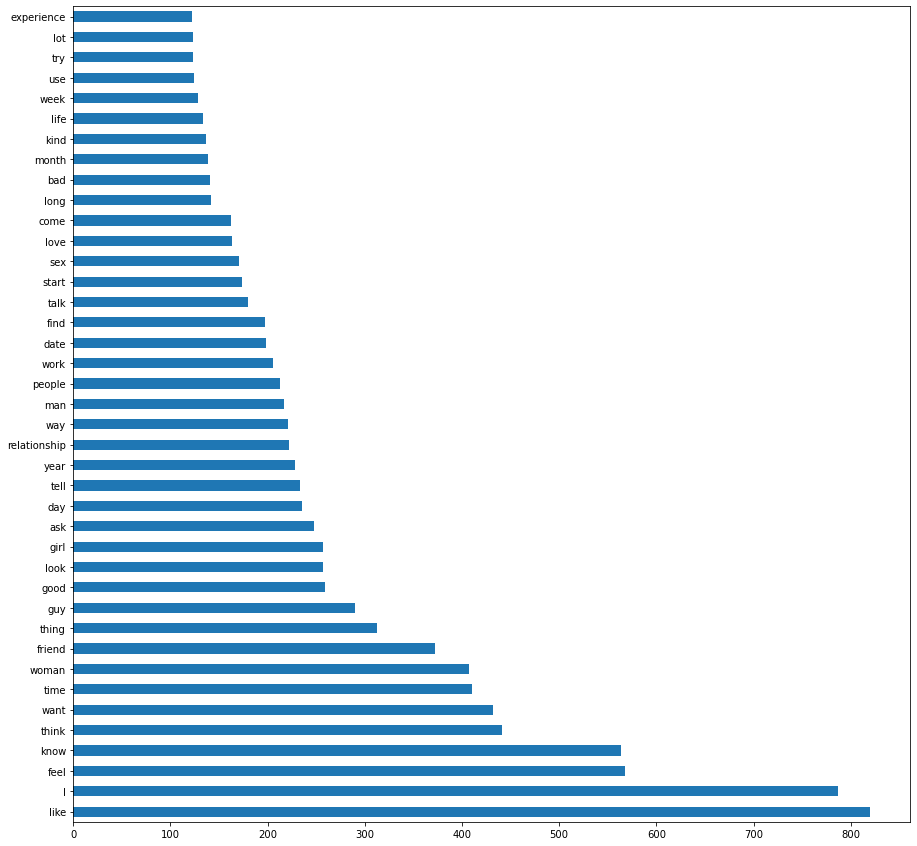

In [1528]:
plt.figure(figsize=(15,15))
df_woman_tokens_stopwords["lemma"].value_counts().sort_values(ascending=False).head(40).plot(kind="barh")

In [1529]:
print(df_man_tokens_stopwords.shape[0])
len(set(df_man_tokens_stopwords["lemma"]))

55592


5872

In [1530]:
print(df_woman_tokens_stopwords.shape[0])
len(set(df_woman_tokens_stopwords["lemma"]))
 

38817


5142

In [1531]:
df_woman_tokens_stopwords.reset_index(inplace=True)
df_woman_tokens_stopwords.drop(columns='index',inplace=True)
df_man_tokens_stopwords.reset_index(inplace=True)
df_man_tokens_stopwords.drop(columns='index',inplace=True)
df_woman_tokens_stopwords



,text,POS,POS explained,lemma
0,I,PRON,pronoun,I
1,find,VERB,verb,find
2,trouble,NOUN,noun,trouble
3,miss,VERB,verb,miss
4,ex,PROPN,proper noun,ex
...,...,...,...,...
38812,suggestion,NOUN,noun,suggestion
38813,story,NOUN,noun,story
38814,girl,NOUN,noun,girl
38815,girl,NOUN,noun,girl


In [1532]:
df_woman_tokens_stopwords

,text,POS,POS explained,lemma
0,I,PRON,pronoun,I
1,find,VERB,verb,find
2,trouble,NOUN,noun,trouble
3,miss,VERB,verb,miss
4,ex,PROPN,proper noun,ex
...,...,...,...,...
38812,suggestion,NOUN,noun,suggestion
38813,story,NOUN,noun,story
38814,girl,NOUN,noun,girl
38815,girl,NOUN,noun,girl


In [1533]:
modeling_set_2_w=df_woman_tokens_stopwords[["lemma"]]
modeling_set_2_m=df_man_tokens_stopwords[["lemma"]]
modeling_set_2_w["sex"]=0
modeling_set_2_m['sex']=1
modeling_set_2=pd.concat([modeling_set_2_w,modeling_set_2_m]);
modeling_set_2.reset_index(inplace=True,drop=True)
modeling_set_2

/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,lemma,sex
0,I,0
1,find,0
2,trouble,0
3,miss,0
4,ex,0
...,...,...
94404,nice,1
94405,guy,1
94406,ghost,1
94407,wonder,1


In [1534]:
modeling_set_2.to_csv('../data/df_submissions_2nd.csv',index=False)

In [1535]:
df_man_tokens_stopwords_uniq=df_man_tokens_stopwords.drop_duplicates('lemma')
df_woman_tokens_stopwords_uniq=df_woman_tokens_stopwords.drop_duplicates('lemma')

In [1536]:
df_man_tokens_stopwords_uniq

,text,POS,POS explained,lemma
0,happen,VERB,verb,happen
1,today,NOUN,noun,today
2,tell,VERB,verb,tell
3,friend,NOUN,noun,friend
4,talk,NOUN,noun,talk
...,...,...,...,...
55561,verse,NOUN,noun,verse
55571,cuff,NOUN,noun,cuff
55573,pullin,VERB,verb,pullin
55574,spank,NOUN,noun,spank
